# **Setup**

In [1]:
!pip -q install datasets transformers accelerate scikit-learn nltk matplotlib

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import nltk; nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer

from torch.nn.functional import softmax
import torch

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **Loading dataset**

In [3]:
from datasets import load_dataset
ds = load_dataset("imdb")
train = ds["train"]
test  = ds["test"]

train = train.shuffle(seed=42)
val = train.select(range(2000))
train = train.select(range(2000, len(train)))
len(train), len(val), len(test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(23000, 2000, 25000)

In [4]:
pd.Series(train["label"]).value_counts()
pd.Series(test["label"]).value_counts()

,count
0,12500
1,12500


In [5]:
print(train[:5])   # first 5 rows

{'text': ["This film features Ben Chaplin as a bored bank employee in England who orders a mail order bride from Russia, recieves Nicole Kidman in the mail and gets more than he bargained for when, surprise, she isn't what she appears to be. The story is fairly predictible and Chaplin underacts too much to the point where he becomes somewhat anoying. Kidman is actualy rather good in this role, making her character about the only thing in this film that is interesting. GRADE: C", 'By no means a masterpiece, and far from Errol Flynn\'s best, Istanbul still has much going for it. The locations and beautiful technicolour cinematography, bring us back to a time long since past. Errol Flynn does show moments of his past glory, and is OK as Jim Brennan, a pilot who\'s past comes back to haunt him. The picture is actually a remake of 1947\'s "Singapore", and the story seems awfully contrived and cliche\' by today\'s standards. Also many of the supporting cast seem to be simply "going through t

# **1. Rule based(VADER)**

In [6]:
sia = SentimentIntensityAnalyzer()

def vader_pred(text):
    s = sia.polarity_scores(text)["compound"]
    return 1 if s >= 0 else 0  # >=0 positive else negative

y_true = test["label"]
y_pred = [vader_pred(t) for t in test["text"]]

print("VADER Acc:", accuracy_score(y_true, y_pred))
print("VADER F1 :", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

VADER Acc: 0.69832
VADER F1 : 0.7403429043586036
              precision    recall  f1-score   support

           0       0.79      0.54      0.64     12500
           1       0.65      0.86      0.74     12500

    accuracy                           0.70     25000
   macro avg       0.72      0.70      0.69     25000
weighted avg       0.72      0.70      0.69     25000



VADER is a quick baseline: fast for sanity(simple) checks, but not SOTA-level performance.

VADER = Valence AWare Dictionary ans sEntiment Reasoner(pre-built sentiment word dictionary)

SOTA = State if the art(Latest best-performing models (like BERT, RoBERTa, GPT, etc, VADER → rule/lexicon based; context capture panna mudiyadhu. So accuracy < modern deep learning models.))

* VADER → very lightweight. No GPU/huge training needed.

* Super fast inference even on large datasets.

# **2. Classic ML(TF-IDF + Logistic rregression)**

In [24]:
X_train, y_train = train["text"], train["label"]
X_val,   y_val   = val["text"],   val["label"]
X_test,  y_test  = test["text"],  test["label"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=200))
])
pipe.fit(X_train, y_train)
joblib.dump(pipe, "tfidf_model.pkl")

pred_val = pipe.predict(X_val)
pred_test = pipe.predict(X_test)
print("Val Acc:", accuracy_score(y_val, pred_val), "F1:", f1_score(y_val, pred_val))
print("Test Acc:", accuracy_score(y_test, pred_test), "F1:", f1_score(y_test, pred_test))
print(classification_report(y_test, pred_test))

Val Acc: 0.9065 F1: 0.9061716006021073
Test Acc: 0.89256 F1: 0.8928599920223375
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



TF-IDF + Logistic Regression gives a solid classical baseline (~89%), much better than VADER, but still below transformer-based SOTA models (>93%).

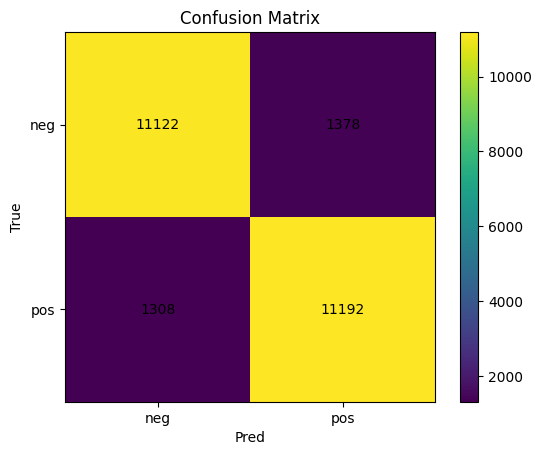

In [8]:
cm = confusion_matrix(y_test, pred_test)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar(); plt.xticks([0,1], ["neg","pos"]); plt.yticks([0,1], ["neg","pos"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

In [9]:
def predict_sentiment(text: str):
    p = pipe.predict_proba([text])[0]
    label = "Positive" if p[1] > 0.5 else "Negative"
    return label, float(p[1])

In [25]:
pipe = joblib.load("tfidf_model.pkl")
print(pipe.predict(["This movie was great"]))  # should output [1]
print(pipe.predict(["This movie was boring"])) # should output [0]

[1]
[0]


# **3. Transformer fine-tuning (DistilBERT)**

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)
tok_train = train.map(tokenize, batched=True)
tok_val   = val.map(tokenize, batched=True)
tok_test  = test.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

args = TrainingArguments(
    output_dir="sentiment-model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_train,
    eval_dataset=tok_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate(tok_test)


In [ ]:
def predict_transformer(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        out = model(**inputs)
    probs = softmax(out.logits, dim=-1).numpy().flatten()
    label = "Positive" if probs[1] > 0.5 else "Negative"
    return label, float(probs[1])

In [ ]:
trainer.save_model("sentiment-distilbert")
tokenizer.save_pretrained("sentiment-distilbert")

# **Error analysis**

In [ ]:
wrong = []
preds = pipe.predict(X_test)
for i,(t, y, p) in enumerate(zip(X_test, y_test, preds)):
    if y != p:
        wrong.append((t, y, p))
wrong[:5]  # sample mistakes

# **Streamlit part**

In [11]:
import base64

def get_base64_of_bin_file(bin_file):
    with open(bin_file, "rb") as f:
        data = f.read()
    return base64.b64encode(data).decode()

bg_img = get_base64_of_bin_file("/content/bg4.jpg")

In [30]:
%%writefile app.py
import streamlit as st
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
import base64
import joblib

--- Load model & tokenizer ---
@st.cache_resource
def load_model():
    model_path = "sentiment-distilbert"   # folder saved after training
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    return tokenizer, model

tokenizer, model = load_model()

# @st.cache_resource
# def load_model():
#     pipe = joblib.load("/content/tfidf_model.pkl")
#     return pipe
# pipe = load_model()

--- Prediction function ---
def predict_sentiment(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=-1).numpy().flatten()
    label = "Positive 😀" if probs[1] > 0.5 else "Negative 😞"
    return label, float(probs[1])

# def predict_sentiment(text: str):
#     pred = pipe.predict([text])[0]
#     prob = pipe.predict_proba([text])[0][1]  # probability of positive
#     label = "Positive 😀" if pred == 1 else "Negative 😞"
#     return label, prob
#  ----------------------------
# --- Function to encode local image ---
def get_base64_of_bin_file(bin_file):
    with open(bin_file, "rb") as f:
        data = f.read()
    return base64.b64encode(data).decode()

# --- Background image (replace bg.jpg with your file) ---
bg_img = get_base64_of_bin_file("/content/bg4.jpg")

page_bg = f"""
<style>
[data-testid="stAppViewContainer"] {{
    background-image: url("data:image/jpg;base64,{bg_img}");
    background-size: cover;
    background-position: center;
    background-attachment: fixed;
    color: black;
}}
[data-testid="stHeader"], [data-testid="stToolbar"] {{
    background: rgba(0,0,0,0);
}}
h1, h2, h3, h4, h5, h6, p, div, span, label {{
    color: white !important;
}}
.stTextInput > div > div > input,
.stTextArea > div > textarea {{
    background-color: rgba(255, 255, 255, 0.7);
    color: black !important;
    border-radius: 10px;
}}
.stButton button {{
    background-color: black;
    color: white;
    border-radius: 10px;
    padding: 0.5em 1em;
}}
</style>
"""
st.markdown(page_bg, unsafe_allow_html=True)

# --- Streamlit UI ---
st.set_page_config(page_title="Sentiment Analysis using BERT on IMDB reviews", page_icon="🤖", layout="centered")

st.title("🤖 Sentiment Analysis on IMDb reviews using BERT")
st.markdown(
    """
    This app uses a **fine-tuned DistilBERT** model (Hugging Face 🤗)
    to classify IMDB reviews into **Positive** or **Negative** sentiment.
    """
)

txt = st.text_area("💬 Enter a movie review:", height=150)

# if st.button("🔍 Analyze Sentiment"):
#     if txt.strip():
#         label, score = predict_sentiment(txt)
#         st.markdown(f"## Prediction: {label}")
#         st.progress(score if label.startswith("Positive") else 1 - score)
#         st.caption(f"Confidence: {score:.2%}")
#     else:
#         st.warning("⚠️ Please enter some text!")
if st.button("🔍 Analyze Sentiment"):
    if txt.strip():
        label, score = predict_sentiment(txt)

        # Custom styled output box
        st.markdown(
            f"""
            <div style="
                padding: 20px;
                border-radius: 15px;
                background: rgba(0, 0, 0, 0.6);
                text-align: center;
                font-size: 24px;
                font-weight: bold;
                color: {'#4CAF50' if label.startswith('Positive') else '#F44336'};
            ">
                Prediction: {label}
            </div>
            """,
            unsafe_allow_html=True,
        )

        # Progress bar for confidence
        st.progress(score if label.startswith("Positive") else 1 - score)
        st.caption(f"Confidence: {score:.2%}")
    else:
        st.warning("⚠️ Please enter some text!")

st.markdown("---")


Overwriting app.py


In [16]:
# 1. Install
!pip install pyngrok streamlit -q

# 2. Add your ngrok token
!ngrok config add-authtoken 30y06aS09CrHLdHMts1Ip0TG3ro_7vpAv7SSNQ1h5HJdfHu3K

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
# 3. Run Streamlit in background
!nohup streamlit run app.py --server.port 8501 --server.address 0.0.0.0 >/dev/null 2>&1 &

In [18]:
# 4. Tunnel port 8501
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Streamlit App URL:", public_url)


Streamlit App URL: NgrokTunnel: "https://384e1f278bf0.ngrok-free.app" -> "http://localhost:8501"
